# IEEE-CIS NLP – EDA → Contract Mapping
## Guardian Project – NLP Stream (Luis Mateo Sánchez)

This notebook focuses on **IEEE-CIS Fraud Detection** (Kaggle) and covers:
- Lightweight EDA (memory-safe)
- Fraud label distribution (`isFraud`)
- Identifying fields that can be transformed into **merchant / transaction-context text**
- Building **merchant_text** and a **canonical NLPInput contract** record
- Exporting an interim dataset ready for NLP experiments


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

pd.set_option('display.max_columns', None)
print('Ready ✅')

Ready ✅


## 1) Load IEEE-CIS (memory-safe)

IEEE-CIS can be large. We start by loading only the columns we need for:
- labels (`isFraud`)
- transaction amount (`TransactionAmt`)
- a few categorical fields to build **merchant_text**

You can increase `NROWS` or set it to `None` once you're comfortable with memory usage.


In [ ]:
TX_PATH = Path('../data/raw/ieee/train_transaction.csv')
ID_PATH = Path('../data/raw/ieee/train_identity.csv')

# Start small for EDA; set to None to load full file later
NROWS = 200_000  # change to None if you want full load

tx_usecols = [
    'TransactionID',
    'isFraud',
    'TransactionAmt',
    'ProductCD',
    'card4',
    'card6',
    'addr1',
    'addr2',
    'P_emaildomain',
    'R_emaildomain'
]

# Dtypes to reduce memory
tx_dtypes = {
    'TransactionID': 'int32',
    'isFraud': 'int8',
    'TransactionAmt': 'float32',
    'ProductCD': 'category',
    'card4': 'category',
    'card6': 'category',
    'addr1': 'float32',
    'addr2': 'float32',
    'P_emaildomain': 'category',
    'R_emaildomain': 'category'
}

df_tx = pd.read_csv(TX_PATH, usecols=tx_usecols, dtype=tx_dtypes, nrows=NROWS)
print('Transactions loaded:', df_tx.shape)
df_tx.head()

Transactions loaded: (200000, 10)


,TransactionID,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain
0,2987000,0,68.5,W,discover,credit,315.0,87.0,NaN,NaN
1,2987001,0,29.0,W,mastercard,credit,325.0,87.0,gmail.com,NaN
2,2987002,0,59.0,W,visa,debit,330.0,87.0,outlook.com,NaN
3,2987003,0,50.0,W,mastercard,debit,476.0,87.0,yahoo.com,NaN
4,2987004,0,50.0,H,mastercard,credit,420.0,87.0,gmail.com,NaN


### Optional: join a few identity fields
Identity has device/browser context that can be useful for merchant/context text.
We only pull a handful of columns.


In [3]:
id_usecols = ['TransactionID', 'DeviceType', 'DeviceInfo', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
id_dtypes = {c: 'category' for c in id_usecols if c != 'TransactionID'}
id_dtypes['TransactionID'] = 'int32'

df_id = pd.read_csv(ID_PATH, usecols=id_usecols, dtype=id_dtypes, nrows=NROWS)
print('Identity loaded:', df_id.shape)

df = df_tx.merge(df_id, on='TransactionID', how='left')
print('Merged:', df.shape)
df.head()

Identity loaded: (144233, 11)
Merged: (200000, 20)


,TransactionID,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,68.5,W,discover,credit,315.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,29.0,W,mastercard,credit,325.0,87.0,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,59.0,W,visa,debit,330.0,87.0,outlook.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,50.0,W,mastercard,debit,476.0,87.0,yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,50.0,H,mastercard,credit,420.0,87.0,gmail.com,NaN,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## 2) Quick EDA (labels, missingness, key distributions)

IEEE-CIS is **highly imbalanced**. For fraud detection, **Accuracy is not informative**.

**Metrics we care about later**:
- **Recall** (primary)
- **PR-AUC** (very important in imbalanced data)
- F1
- ROC-AUC


In [4]:
df['isFraud'].value_counts(), df['isFraud'].value_counts(normalize=True)

(isFraud
 0    193976
 1      6024
 Name: count, dtype: int64,
 isFraud
 0    0.96988
 1    0.03012
 Name: proportion, dtype: float64)

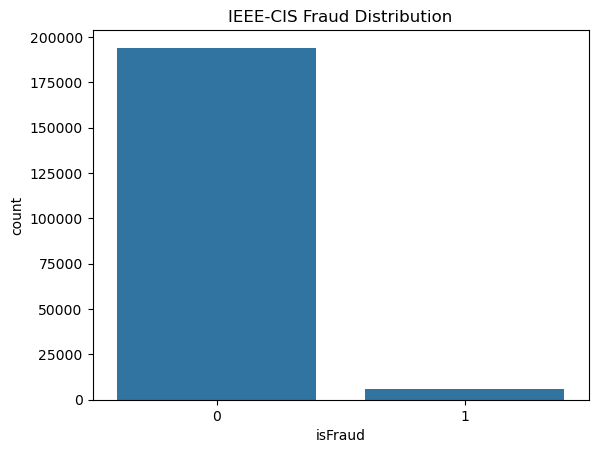

In [5]:
sns.countplot(x='isFraud', data=df)
plt.title('IEEE-CIS Fraud Distribution')
plt.show()

In [6]:
missing = (df.isna().mean().sort_values(ascending=False) * 100)
missing.head(15)

id_33            78.2880
id_30            76.6140
id_34            76.5800
DeviceInfo       69.7435
R_emaildomain    68.1760
id_31            65.8525
DeviceType       65.8130
id_35            65.7510
id_36            65.7510
id_37            65.7510
id_38            65.7510
P_emaildomain    16.0795
addr1            10.6960
addr2            10.6960
card4             0.0045
dtype: float64

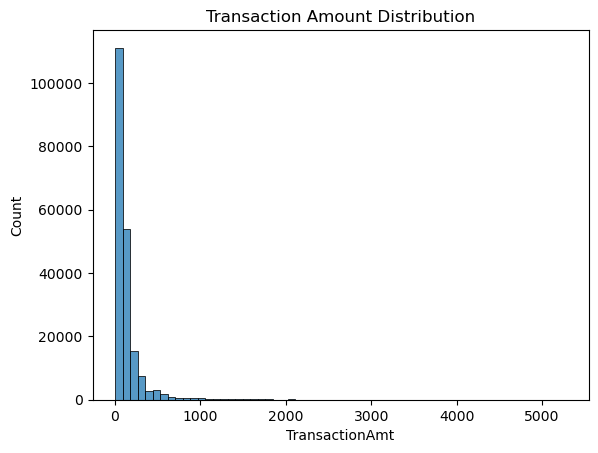

In [7]:
sns.histplot(df['TransactionAmt'], bins=60)
plt.title('Transaction Amount Distribution')
plt.show()

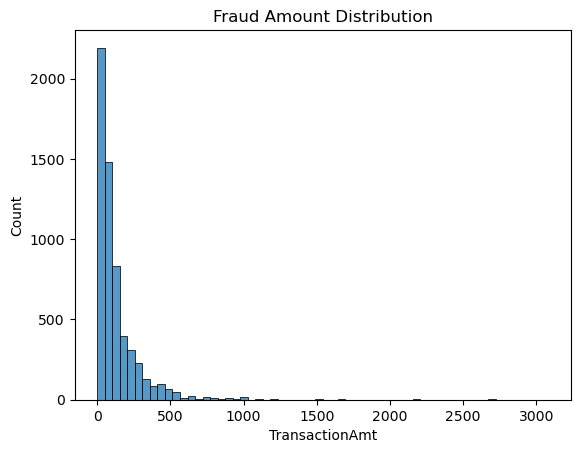

In [8]:
sns.histplot(df.loc[df['isFraud']==1, 'TransactionAmt'], bins=60)
plt.title('Fraud Amount Distribution')
plt.show()

## 3) Build merchant / context text

IEEE-CIS does not include natural language descriptions by default. We create a **merchant/context text** that mimics
what a real payment processor might provide as a short transaction context.

We deliberately keep this text:
- **structured** (consistent)
- **dataset-agnostic** (portable)
- ready to map into the **NLPInput contract**


In [9]:
def safe_str(x):
    if pd.isna(x):
        return 'unknown'
    return str(x)

def build_ieee_merchant_text(row):
    parts = [
        f"Product category: {safe_str(row.get('ProductCD'))}",
        f"Card network: {safe_str(row.get('card4'))}",
        f"Card type: {safe_str(row.get('card6'))}",
        f"Payer email domain: {safe_str(row.get('P_emaildomain'))}",
        f"Receiver email domain: {safe_str(row.get('R_emaildomain'))}",
        f"Device type: {safe_str(row.get('DeviceType'))}",
        f"Device info: {safe_str(row.get('DeviceInfo'))}",
        f"Browser/OS: {safe_str(row.get('id_31'))} / {safe_str(row.get('id_30'))}",
        f"Resolution: {safe_str(row.get('id_33'))}",
        f"Address hints: addr1={safe_str(row.get('addr1'))}, addr2={safe_str(row.get('addr2'))}",
    ]
    return '. '.join(parts) + '.'

df['merchant_text'] = df.apply(build_ieee_merchant_text, axis=1)
df[['TransactionID','merchant_text']].head(3)

,TransactionID,merchant_text
0,2987000,Product category: W. Card network: discover. C...
1,2987001,Product category: W. Card network: mastercard....
2,2987002,Product category: W. Card network: visa. Card ...


## 4) Map to Canonical Internal Contract (NLPInput)

For IEEE-CIS we will:
- use `TransactionID` as `transaction_id`
- use `merchant_text` as `text`
- set `text_source = "merchant"`
- set `language = "en"` (placeholder)
- include `amount` and `transaction_type/product` in metadata


In [10]:
def to_nlp_input(row):
    return {
        'transaction_id': str(int(row['TransactionID'])),
        'text': row['merchant_text'],
        'text_source': 'merchant',
        'language': 'en',
        'metadata': {
            'amount': None if pd.isna(row['TransactionAmt']) else float(row['TransactionAmt']),
            'transaction_type': safe_str(row.get('ProductCD')),
            'channel': safe_str(row.get('DeviceType')),
            # currency/country are not available in IEEE-CIS; keep them optional
        }
    }

example = to_nlp_input(df.iloc[0])
example

{'transaction_id': '2987000',
 'text': 'Product category: W. Card network: discover. Card type: credit. Payer email domain: unknown. Receiver email domain: unknown. Device type: unknown. Device info: unknown. Browser/OS: unknown / unknown. Resolution: unknown. Address hints: addr1=315.0, addr2=87.0.',
 'text_source': 'merchant',
 'language': 'en',
 'metadata': {'amount': 68.5, 'transaction_type': 'W', 'channel': 'unknown'}}

## 5) Build an interim NLP dataset (text + label)

For modeling experiments, we prepare an ML-ready dataset:
- `transaction_id`
- `text`
- `label` (from `isFraud`)
- optional metadata fields


In [11]:
df_nlp = pd.DataFrame({
    'transaction_id': df['TransactionID'].astype('int64').astype(str),
    'text': df['merchant_text'],
    'label': df['isFraud'].astype('int8'),
    'amount': df['TransactionAmt'].astype('float32'),
    'productcd': df['ProductCD'].astype(str),
    'device_type': df['DeviceType'].astype(str)
})

df_nlp.head()

,transaction_id,text,label,amount,productcd,device_type
0,2987000,Product category: W. Card network: discover. C...,0,68.5,W,nan
1,2987001,Product category: W. Card network: mastercard....,0,29.0,W,nan
2,2987002,Product category: W. Card network: visa. Card ...,0,59.0,W,nan
3,2987003,Product category: W. Card network: mastercard....,0,50.0,W,nan
4,2987004,Product category: H. Card network: mastercard....,0,50.0,H,mobile


In [12]:
out_dir = Path('../data/interim/ieee')
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / 'ieee_nlp_interim.csv'
df_nlp.to_csv(csv_path, index=False)
print('Saved:', csv_path)

jsonl_path = out_dir / 'ieee_nlpinput_sample.jsonl'
with open(jsonl_path, 'w', encoding='utf-8') as f:
    for i in range(min(200, len(df))):
        f.write(json.dumps(to_nlp_input(df.iloc[i]), ensure_ascii=False) + '\n')
print('Saved:', jsonl_path)

Saved: ../data/interim/ieee/ieee_nlp_interim.csv
Saved: ../data/interim/ieee/ieee_nlpinput_sample.jsonl


## 6) Quick checklist

- [ ] Confirm `TX_PATH` and `ID_PATH` match your folder structure
- [ ] Run EDA cells (fraud distribution, missingness, amount)
- [ ] Verify `merchant_text` quality
- [ ] Validate `to_nlp_input()` output
- [ ] Ensure interim files are saved in `../data/interim/ieee/`
